In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from scipy.stats import entropy
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


DATA

In [2]:
lobster_data = np.load('vwap.npy')

indices = np.arange(lobster_data.shape[0])
np.random.shuffle(indices)
lobster_data = lobster_data[indices]
pct_changes = np.diff(lobster_data, axis=1) / lobster_data[:, :-1]

PCT_Prices = pct_changes[:,100:202]

In [3]:
token_limit = 0.005

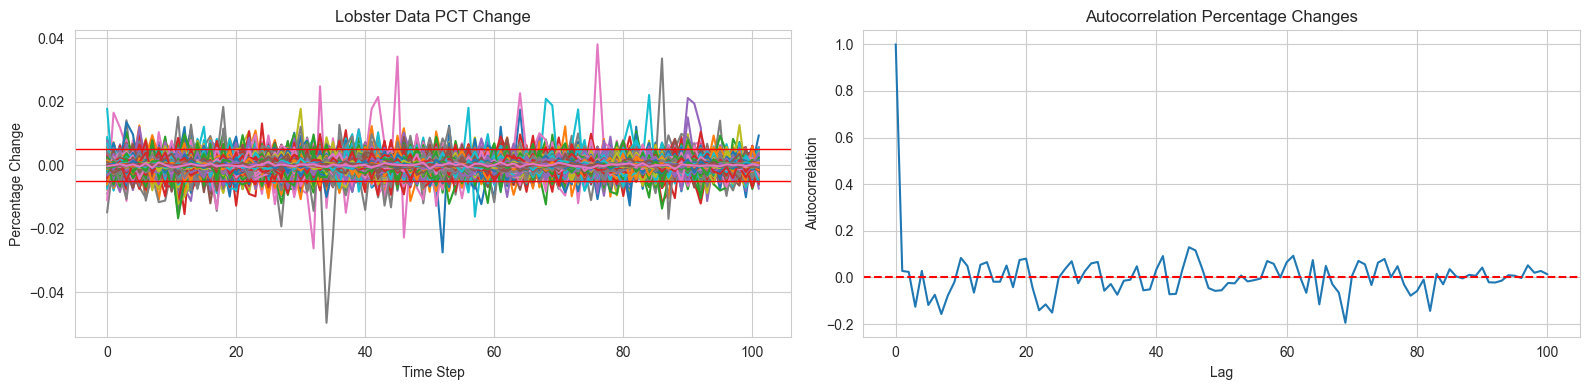

In [4]:
acf_values = acf(PCT_Prices[0], nlags=100)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

ax1.plot(PCT_Prices.T)
ax1.axhline(token_limit, color='red', linewidth=1)
ax1.axhline(-token_limit, color='red', linewidth=1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Percentage Change')
ax1.set_title('Lobster Data PCT Change')

ax2.plot(range(len(acf_values)), acf_values)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Autocorrelation Percentage Changes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

FUNCTIONS

In [5]:
def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    return tokenized_sequences

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

def transfer_weights_from_saved(weights_path, ppo_model, transfer_head, input_dim, hidden_dim, output_dim):
    """
    Load saved supervised weights and transfer to PPO model with optional head transfer
    
    Args:
        weights_path: Path to the saved supervised model weights
        ppo_model: The PPO model to transfer weights to
        transfer_head: If True, also transfer fc layer weights to action_net
        input_dim: Input dimension of the supervised model
        hidden_dim: Hidden dimension of the supervised model
        output_dim: Output dimension of the supervised model
    """
    # Create temporary supervised model to load weights into
    temp_supervised = LSTMModel(input_dim, hidden_dim, output_dim)
    
    # Load the saved weights
    saved_weights = th.load(weights_path, weights_only=False)
    temp_supervised.load_state_dict(saved_weights['model_state_dict'])
    
    print("Loaded saved supervised weights successfully")
    
    # Transfer LSTM weights
    print("\n=== Transferring LSTM Weights ===")
    supervised_state_dict = temp_supervised.state_dict()
    ppo_lstm_dict = ppo_model.policy.lstm_actor.state_dict()
    
    # Print shapes before transfer for verification
    print("\nWeight shapes before transfer:")
    print("\nSupervised LSTM weights:")
    for key, value in supervised_state_dict.items():
        if 'lstm' in key:
            print(f"{key}: {value.shape}")
    
    print("\nPPO LSTM weights:")
    for key, value in ppo_lstm_dict.items():
        print(f"{key}: {value.shape}")
    
    # Transfer LSTM weights
    lstm_transfer_count = 0
    for ppo_key in ppo_lstm_dict.keys():
        supervised_key = f"lstm.{ppo_key}"
        if supervised_key in supervised_state_dict:
            if ppo_lstm_dict[ppo_key].shape == supervised_state_dict[supervised_key].shape:
                ppo_lstm_dict[ppo_key].copy_(supervised_state_dict[supervised_key])
                lstm_transfer_count += 1
                print(f"Transferred weights for {ppo_key}")
            else:
                print(f"Shape mismatch for {ppo_key}")
    
    # Load the LSTM weights
    ppo_model.policy.lstm_actor.load_state_dict(ppo_lstm_dict)
    print(f"\nSuccessfully transferred {lstm_transfer_count} LSTM weight tensors")
    
    # Transfer head weights if requested
    if transfer_head:
        print("\n=== Transferring Head Weights ===")
        # Get supervised fc weights and biases
        fc_weight = supervised_state_dict['fc.weight']
        fc_bias = supervised_state_dict['fc.bias']
        
        # Get PPO action_net weights and biases
        action_net_state_dict = ppo_model.policy.action_net.state_dict()
        
        print("\nHead weight shapes:")
        print(f"Supervised fc weight: {fc_weight.shape}")
        print(f"Supervised fc bias: {fc_bias.shape}")
        print(f"PPO action_net weight: {action_net_state_dict['weight'].shape}")
        print(f"PPO action_net bias: {action_net_state_dict['bias'].shape}")
        
        # Verify shapes match before transfer
        if (fc_weight.shape == action_net_state_dict['weight'].shape and 
            fc_bias.shape == action_net_state_dict['bias'].shape):
            # Transfer weights
            action_net_state_dict['weight'].copy_(fc_weight)
            action_net_state_dict['bias'].copy_(fc_bias)
            ppo_model.policy.action_net.load_state_dict(action_net_state_dict)
            print("Successfully transferred head weights")
        else:
            print("Shape mismatch in head weights - transfer aborted")
    
    return ppo_model


In [6]:
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(PCT_Prices)),5))

Standard Deviation of Price Deltas: 0.00064


In [7]:
bin_width = np.std(np.concatenate(PCT_Prices)) / 8
bin_start=-token_limit
bin_stop=token_limit
token_size = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins

token_data = tokenize_deltas(PCT_Prices, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

FUNCTIONS

In [34]:
def plot_price_token(price_data, token_data, bins, token_limit):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    ax1, ax2, ax3, ax4 = axes.ravel()

    # Time Series
    ax1.plot(price_data.T)
    ax1.axhline(token_limit, color='red', linewidth=1)
    ax1.axhline(-token_limit, color='red', linewidth=1)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Percentage Change')
    ax1.set_title('Time Series')

    # Boxplot Time Series
    ax2.boxplot(np.concatenate(price_data), vert=True)
    ax2.axhline(token_limit, color='red', linewidth=1)
    ax2.axhline(-token_limit, color='red', linewidth=1)
    ax2.set_title('Boxplot PCT Change')
    ax2.set_ylabel('Percentage Change')

    # Histogram
    ax3.hist(np.concatenate(token_data), bins=bins, edgecolor='blue', color='orange', density=True)
    ax3.set_title('Histogram: Lobster Data PCT Change')
    ax3.set_xlabel('PCT Change')
    ax3.set_ylabel('Frequency')

    # 99% Data Histogram
    ax4.hist(np.concatenate(token_data), bins=bins, edgecolor='orange', color='blue', density=True)
    ax4.set_xlim(np.quantile(np.concatenate(token_data), q=0.005),np.quantile(np.concatenate(token_data), q=0.995))
    ax4.set_title('Histogram: 99% of Data')
    ax4.set_xlabel('PCT Change')
    ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()  

def supervised_wasserstein(real_data, supervised_data):
    n_timesteps = real_data.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_data[:, t], supervised_data[:, t])
        wasserstein_supervised.append(w_dist)

    # Create visualization
    fig = plt.figure(figsize=(12, 4))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 2)
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.legend()

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_data[:, worst_timestep_supervised]
    generated_data = supervised_data[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

def plot_first_n_distributions(real_data, supervised_data, n_steps=10):
    # Create visualization
    plots_per_row = 5
    rows = (n_steps + plots_per_row - 1) // plots_per_row  # Calculate number of rows needed (ceiling division)
    
    fig = plt.figure(figsize=(20, 4 * rows))  # Adjusted figure size to account for 5 plots per row
    gs = plt.GridSpec(rows, plots_per_row)
    
    for t in range(n_steps):
        # Calculate subplot position
        row = t // plots_per_row
        col = t % plots_per_row
        
        # Create subplot
        ax = fig.add_subplot(gs[row, col])
        
        # Get data for the timestep
        real_timestep = real_data[:, t]
        generated_timestep = supervised_data[:, t]
        
        # Calculate KDE
        kde_real = gaussian_kde(real_timestep)
        kde_generated = gaussian_kde(generated_timestep)
        
        # Create evaluation points
        x_eval = np.linspace(min(real_timestep.min(), generated_timestep.min()),
                            max(real_timestep.max(), generated_timestep.max()),
                            200)
        
        # Plot distributions
        ax.plot(x_eval, kde_real(x_eval), label='Real', color='blue', linewidth=0.8)
        ax.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red', linewidth=0.8)
        ax.set_title(f'Timestep {t}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

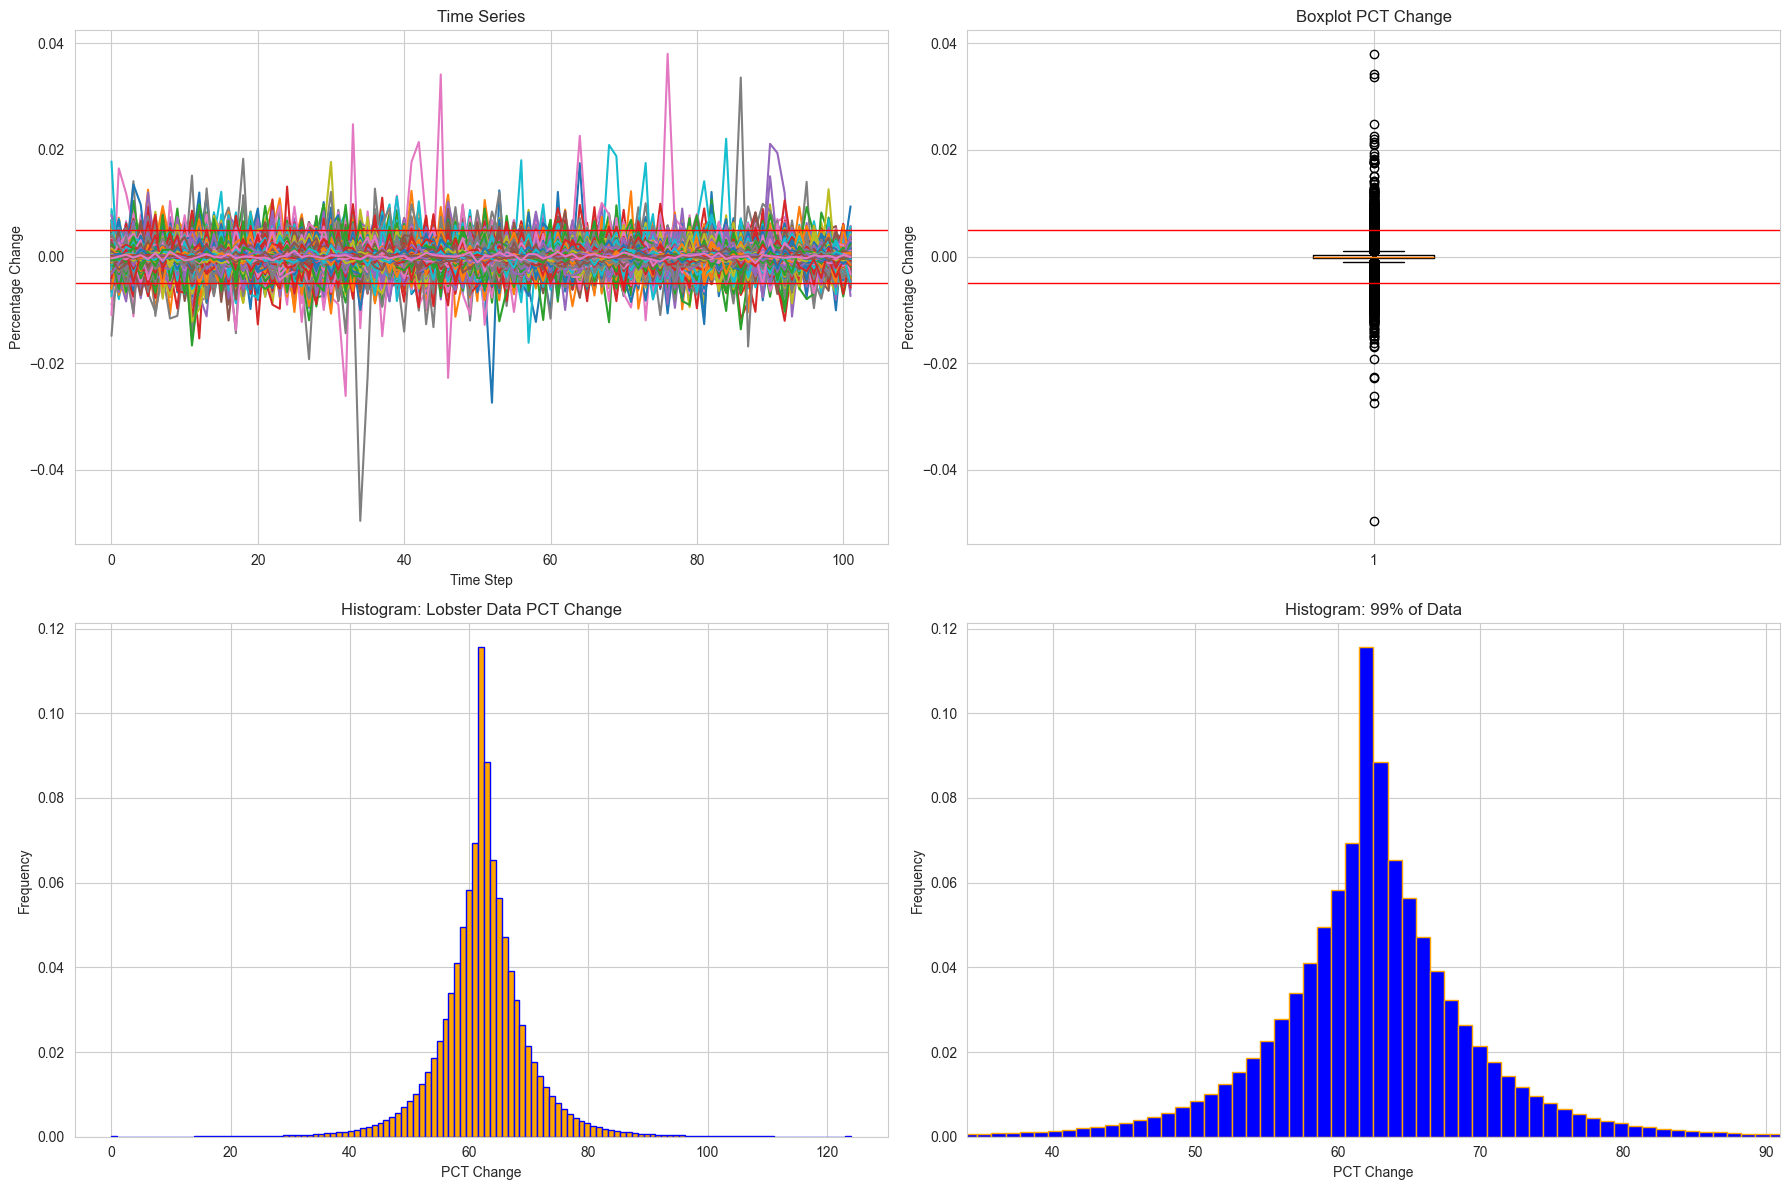

Number of Tokens: 125
Data Shape: (98087, 102)


In [9]:
plot_price_token(price_data=PCT_Prices, token_data=token_data, bins=token_size, token_limit=token_limit)

print('Number of Tokens:', token_size)
print('Data Shape:', PCT_Prices.shape)

In [10]:
n_sequences = PCT_Prices.shape[0]
n_days = PCT_Prices.shape[1]

train_size = int(0.75 * n_sequences)
val_size = int(0.075 * n_sequences)
# Split the data
train_set = PCT_Prices[:train_size]
val_set = PCT_Prices[train_size:train_size+val_size]
test_set = PCT_Prices[train_size+val_size:]

X_train = tokenize_deltas(train_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)
X_val = tokenize_deltas(val_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)
X_test = tokenize_deltas(test_set, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

# Print shapes to verify
print("Training set shape:", X_train.shape)    # Should be around (73565, 202)
print("Validation set shape:", X_val.shape)    # Should be around (12260, 202)
print("Test set shape:", X_test.shape)         # Should be around (12262, 202)

Training set shape: (73565, 102)
Validation set shape: (7356, 102)
Test set shape: (17166, 102)


#### SUPERVISED TRAINING

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Changed default input_dim
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # x shape now: [batch_size, sequence_length, vocab_size]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (h_n, c_n)

def to_onehot(tokens, vocab_size):
    """Convert batch of tokens to one-hot vectors using efficient PyTorch operations"""
    batch_size, seq_length = tokens.shape
    # Create indices tensor
    onehot = th.zeros(batch_size, seq_length, vocab_size, device=tokens.device)
    # Use scatter_ for efficient one-hot encoding
    return onehot.scatter_(2, tokens.unsqueeze(-1), 1)

In [15]:
# Rest of your parameters remain the same
hidden_dim = 128
batch_size = 256
learning_rate = 2e-4
seq_len = n_days-1
num_epochs = 30

In [16]:
# Create model with new input dimension
model_supervised = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
val_loss = []

best_val_loss = float('inf')
max_grad_norm = 1.0

# Pre-allocate tensors for validation to avoid repeated creation
val_input_tokens = th.tensor(X_val[:, :-1], dtype=th.long)
val_targets = th.tensor(X_val[:, 1:], dtype=th.long)
val_onehot = to_onehot(val_input_tokens, token_size)

# Convert training data to tensors once before training loop
train_tokens = th.tensor(X_train, dtype=th.long)

for epoch in range(num_epochs):
    
    temp_train_loss = []
    temp_val_loss = []

    ## ============
    ## TRAINING
    ## ============

    model_supervised.train()
    
    indices = th.randperm(X_train.shape[0])  # Use PyTorch's randperm instead of numpy

    for batch_idx in range(0, X_train.shape[0], batch_size):
        
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_tokens[batch_indices]

        input_tokens = batch[:, :-1]
        inputs = to_onehot(input_tokens, token_size)
        targets = batch[:, 1:]

        logits, _ = model_supervised(inputs, None)
        logits = logits.reshape(-1, logits.size(-1))
        targets = targets.reshape(-1)

        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        loss = criterion_supervised(logits, targets)
        loss.backward()

        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        optimizer.step()
        
        temp_train_loss.append(loss.item())

    ## ============
    ## VALIDATION
    ## ============
        
    model_supervised.eval()

    with th.no_grad():
        logits, _ = model_supervised(val_onehot, None)
        logits = logits.reshape(-1, logits.size(-1))
        targets = val_targets.reshape(-1)
        loss = criterion_supervised(logits, targets)
        temp_val_loss.append(loss.item())
    
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        checkpoint = {
            'model_state_dict': model_supervised.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        th.save(checkpoint, 'supervised_weights_lobster.pth')
    
    train_loss.extend(temp_train_loss)
    val_loss.append(loss.item())  # Only append the last validation loss
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {loss.item():.4f}")

Epoch 1/30 - Train Loss: 3.6010 - Val Loss: 3.3764
Epoch 2/30 - Train Loss: 3.3697 - Val Loss: 3.3658
Epoch 3/30 - Train Loss: 3.3625 - Val Loss: 3.3616
Epoch 4/30 - Train Loss: 3.3568 - Val Loss: 3.3433
Epoch 5/30 - Train Loss: 3.3048 - Val Loss: 3.2803
Epoch 6/30 - Train Loss: 3.2721 - Val Loss: 3.2638
Epoch 7/30 - Train Loss: 3.2601 - Val Loss: 3.2554
Epoch 8/30 - Train Loss: 3.2551 - Val Loss: 3.2519
Epoch 9/30 - Train Loss: 3.2525 - Val Loss: 3.2503
Epoch 10/30 - Train Loss: 3.2510 - Val Loss: 3.2490
Epoch 11/30 - Train Loss: 3.2500 - Val Loss: 3.2470
Epoch 12/30 - Train Loss: 3.2459 - Val Loss: 3.2426
Epoch 13/30 - Train Loss: 3.2437 - Val Loss: 3.2415
Epoch 14/30 - Train Loss: 3.2423 - Val Loss: 3.2411
Epoch 15/30 - Train Loss: 3.2415 - Val Loss: 3.2407
Epoch 16/30 - Train Loss: 3.2409 - Val Loss: 3.2398
Epoch 17/30 - Train Loss: 3.2405 - Val Loss: 3.2394
Epoch 18/30 - Train Loss: 3.2400 - Val Loss: 3.2386
Epoch 19/30 - Train Loss: 3.2398 - Val Loss: 3.2389
Epoch 20/30 - Train L

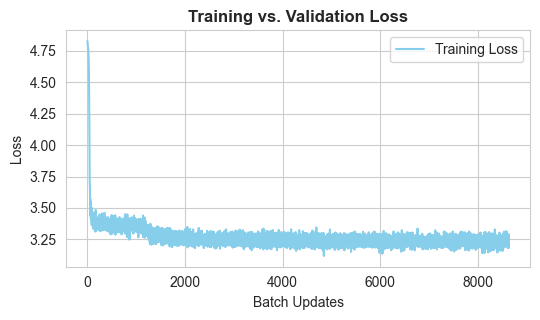

In [17]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Training Loss', color='skyblue', linewidth=1.5)
#plt.plot(val_loss, label='Validation Loss', color='blue', linewidth=1.5)
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

In [18]:
# Update model creation to match new architecture
inference_model = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)
checkpoint = th.load('supervised_weights_lobster.pth')
inference_model.load_state_dict(checkpoint['model_state_dict'])
criterion_inference = nn.CrossEntropyLoss()

test_data_inference = th.tensor(X_test, dtype=th.long)  # Changed to long type

test_losses = []
supervised_data = []

inference_model.eval()

def to_onehot_inference(tokens, vocab_size):
    """Efficient one-hot encoding using scatter"""
    onehot = th.zeros(1, 1, vocab_size)
    return onehot.scatter_(2, tokens.view(1, 1, 1), 1)

with th.no_grad():
    
    for sequence in test_data_inference:
        
        token_loss = 0
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token.item()]  # Store as Python integers
        hidden = None

        last_token = th.zeros(1, dtype=th.long)
        
        for i in range(1, len(sequence)):

            last_token[0] = sim_trajectory[-1]
            input_onehot = to_onehot_inference(last_token, token_size)

            # Get model predictions
            logits, hidden = inference_model(input_onehot, hidden)
            probs = F.softmax(logits, dim=-1).squeeze()

            # Sample next token
            predicted_token = th.multinomial(probs, num_samples=1).item()
            sim_trajectory.append(predicted_token)
            
            # Loss calculation
            true_token = sequence[i].unsqueeze(-1)
            loss = criterion_inference(logits.squeeze(1), true_token.long())
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        supervised_data.append(sim_trajectory[1:])

supervised_data = np.array(supervised_data)

/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_77660/3033626918.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = th.load('supervised_weights_lobs

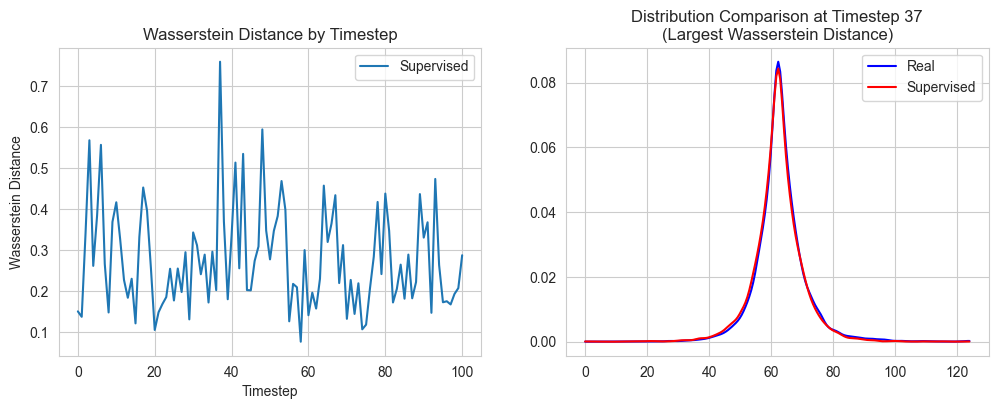

In [19]:
supervised_wasserstein(X_test[:,1:], supervised_data)

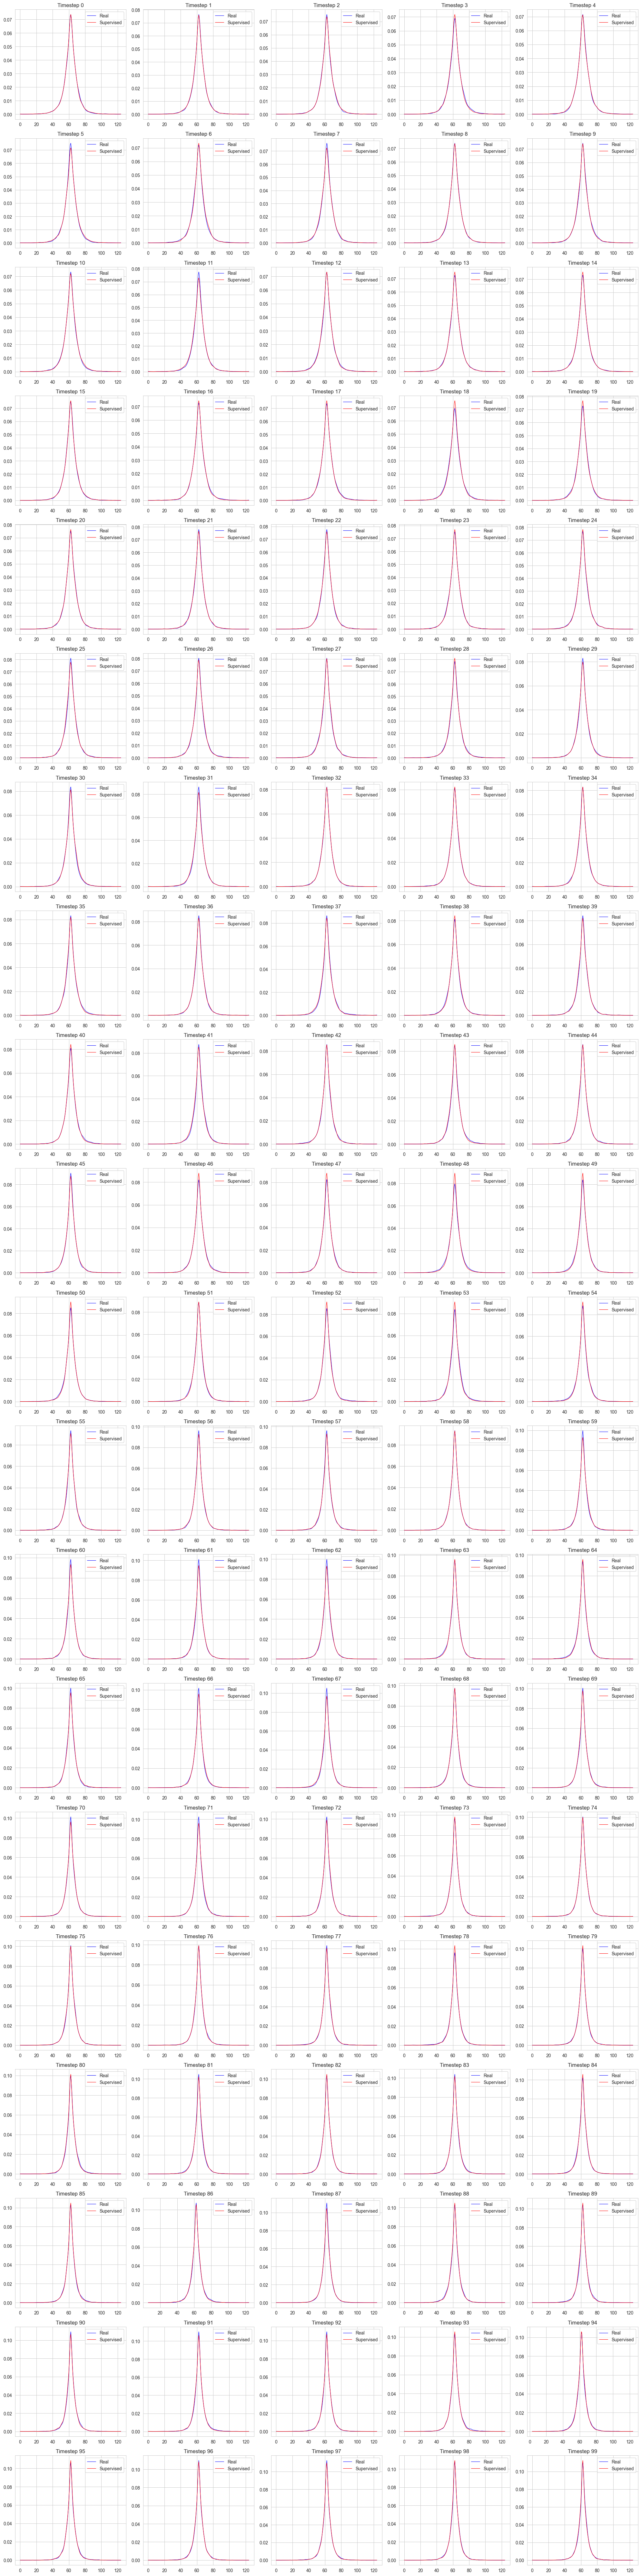

In [36]:
plot_first_n_distributions(X_test[:,1:], supervised_data, n_steps=100)

Without Hot Encoding

In [32]:
class LSTMModel_no_hot_encoding(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel_no_hot_encoding, self).__init__()
        # LSTM Layer with 2 layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # LSTM Layer (with 2 stacked layers)
        # x shape should be: [batch_size, sequence_length, input_dim]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)      # Shape: [batch_size, sequence_length, hidden_dim]
        
        # Apply Fully Connected Layer to each time step
        logits = self.fc(lstm_out)                       # Shape: [batch_size, sequence_length, output_dim]

        return logits, (h_n, c_n)                        # Return predictions for each time step

In [33]:
model_supervised = LSTMModel_no_hot_encoding(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)


criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
val_loss = []

best_val_loss = float('inf')
max_grad_norm = 1.0

for epoch in range(num_epochs):

    temp_train_loss = []
    temp_val_loss = []
    
    ## ============
    ## TRAINING
    ## ============

    # Shuffle the data at the beginning of the epoch
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    for batch_idx in range(0, X_train.shape[0], batch_size):

        model_supervised.train()
        
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = X_train[batch_indices]
        
        inputs = th.tensor(batch[:, :-1], dtype=th.float32).unsqueeze(-1)
        targets = th.tensor(batch[:, 1:], dtype=th.long)
        
        # Forward pass for this batch
        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
        targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
        
        optimizer.zero_grad()  # Reset gradients

        loss = criterion_supervised(logits, targets)
        loss.backward()        # Backpropagation

        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        
        optimizer.step()       # Update the model parameters
        
        
        temp_train_loss.append(loss.item())
        
        ## ============
        ## VALIDATION
        ## ============

        model_supervised.eval()
        
        with th.no_grad():
            inputs = th.tensor(X_val[:2000, :-1], dtype=th.float32).unsqueeze(-1)  # All tokens except the last
            targets = th.tensor(X_val[:2000, 1:], dtype=th.long)  # All tokens except the first

            logits, _ = model_supervised(inputs, None)
            logits = logits.view(-1, logits.size(-1))  # Flatten logits: (batch_size * seq_len, num_bins)
            targets = targets.view(-1)                 # Flatten targets: (batch_size * seq_len)
            
            loss = criterion_supervised(logits, targets)
            temp_val_loss.append(loss.item())
        
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            th.save(model_supervised.state_dict(), 'sw_no_hot_enc.pth')
        
        #print(f"Train Loss: {temp_train_loss[-1]:.4} - Val Loss: {temp_val_loss[-1]:.4}")
    
    train_loss.extend(temp_train_loss)
    val_loss.extend(temp_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")

Epoch 1/30 - Train Loss: 3.6176 - Val Loss: 3.5907
Epoch 2/30 - Train Loss: 3.2875 - Val Loss: 3.2606
Epoch 3/30 - Train Loss: 3.2722 - Val Loss: 3.2457
Epoch 4/30 - Train Loss: 3.2647 - Val Loss: 3.2380
Epoch 5/30 - Train Loss: 3.2603 - Val Loss: 3.2338
Epoch 6/30 - Train Loss: 3.2569 - Val Loss: 3.2307
Epoch 7/30 - Train Loss: 3.2554 - Val Loss: 3.2289
Epoch 8/30 - Train Loss: 3.2538 - Val Loss: 3.2274
Epoch 9/30 - Train Loss: 3.2518 - Val Loss: 3.2254
Epoch 10/30 - Train Loss: 3.2511 - Val Loss: 3.2246
Epoch 11/30 - Train Loss: 3.2502 - Val Loss: 3.2239
Epoch 12/30 - Train Loss: 3.2492 - Val Loss: 3.2227
Epoch 13/30 - Train Loss: 3.2484 - Val Loss: 3.2218
Epoch 14/30 - Train Loss: 3.2481 - Val Loss: 3.2217
Epoch 15/30 - Train Loss: 3.2471 - Val Loss: 3.2208
Epoch 16/30 - Train Loss: 3.2470 - Val Loss: 3.2205
Epoch 17/30 - Train Loss: 3.2464 - Val Loss: 3.2199
Epoch 18/30 - Train Loss: 3.2458 - Val Loss: 3.2193
Epoch 19/30 - Train Loss: 3.2452 - Val Loss: 3.2191
Epoch 20/30 - Train L

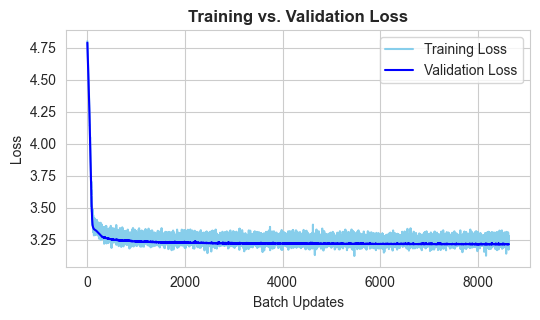

In [34]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_loss, label='Validation Loss', color='blue', linewidth=1.5)
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

In [35]:
inference_model = LSTMModel_no_hot_encoding(input_dim=1, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('sw_no_hot_enc.pth', weights_only=False))



test_data_inference = th.tensor(X_test, dtype=th.float32)  # Changed to long type

supervised_data = []
inference_model.eval()

with th.no_grad():
    for sequence in test_data_inference:
        
        token_loss = 0
        
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]
        
        hidden = None
        
        for i in range(1, len(sequence)):
            # Convert last token to one-hot
            last_token = sim_trajectory[-1].reshape(1, 1, 1)
            
            logits, hidden = inference_model(last_token, hidden)
                
            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())
            
            # Loss calculation
            true_token = sequence[i].unsqueeze(-1)
        
        supervised_data.append(sim_trajectory[1:])

supervised_data = np.array(supervised_data)

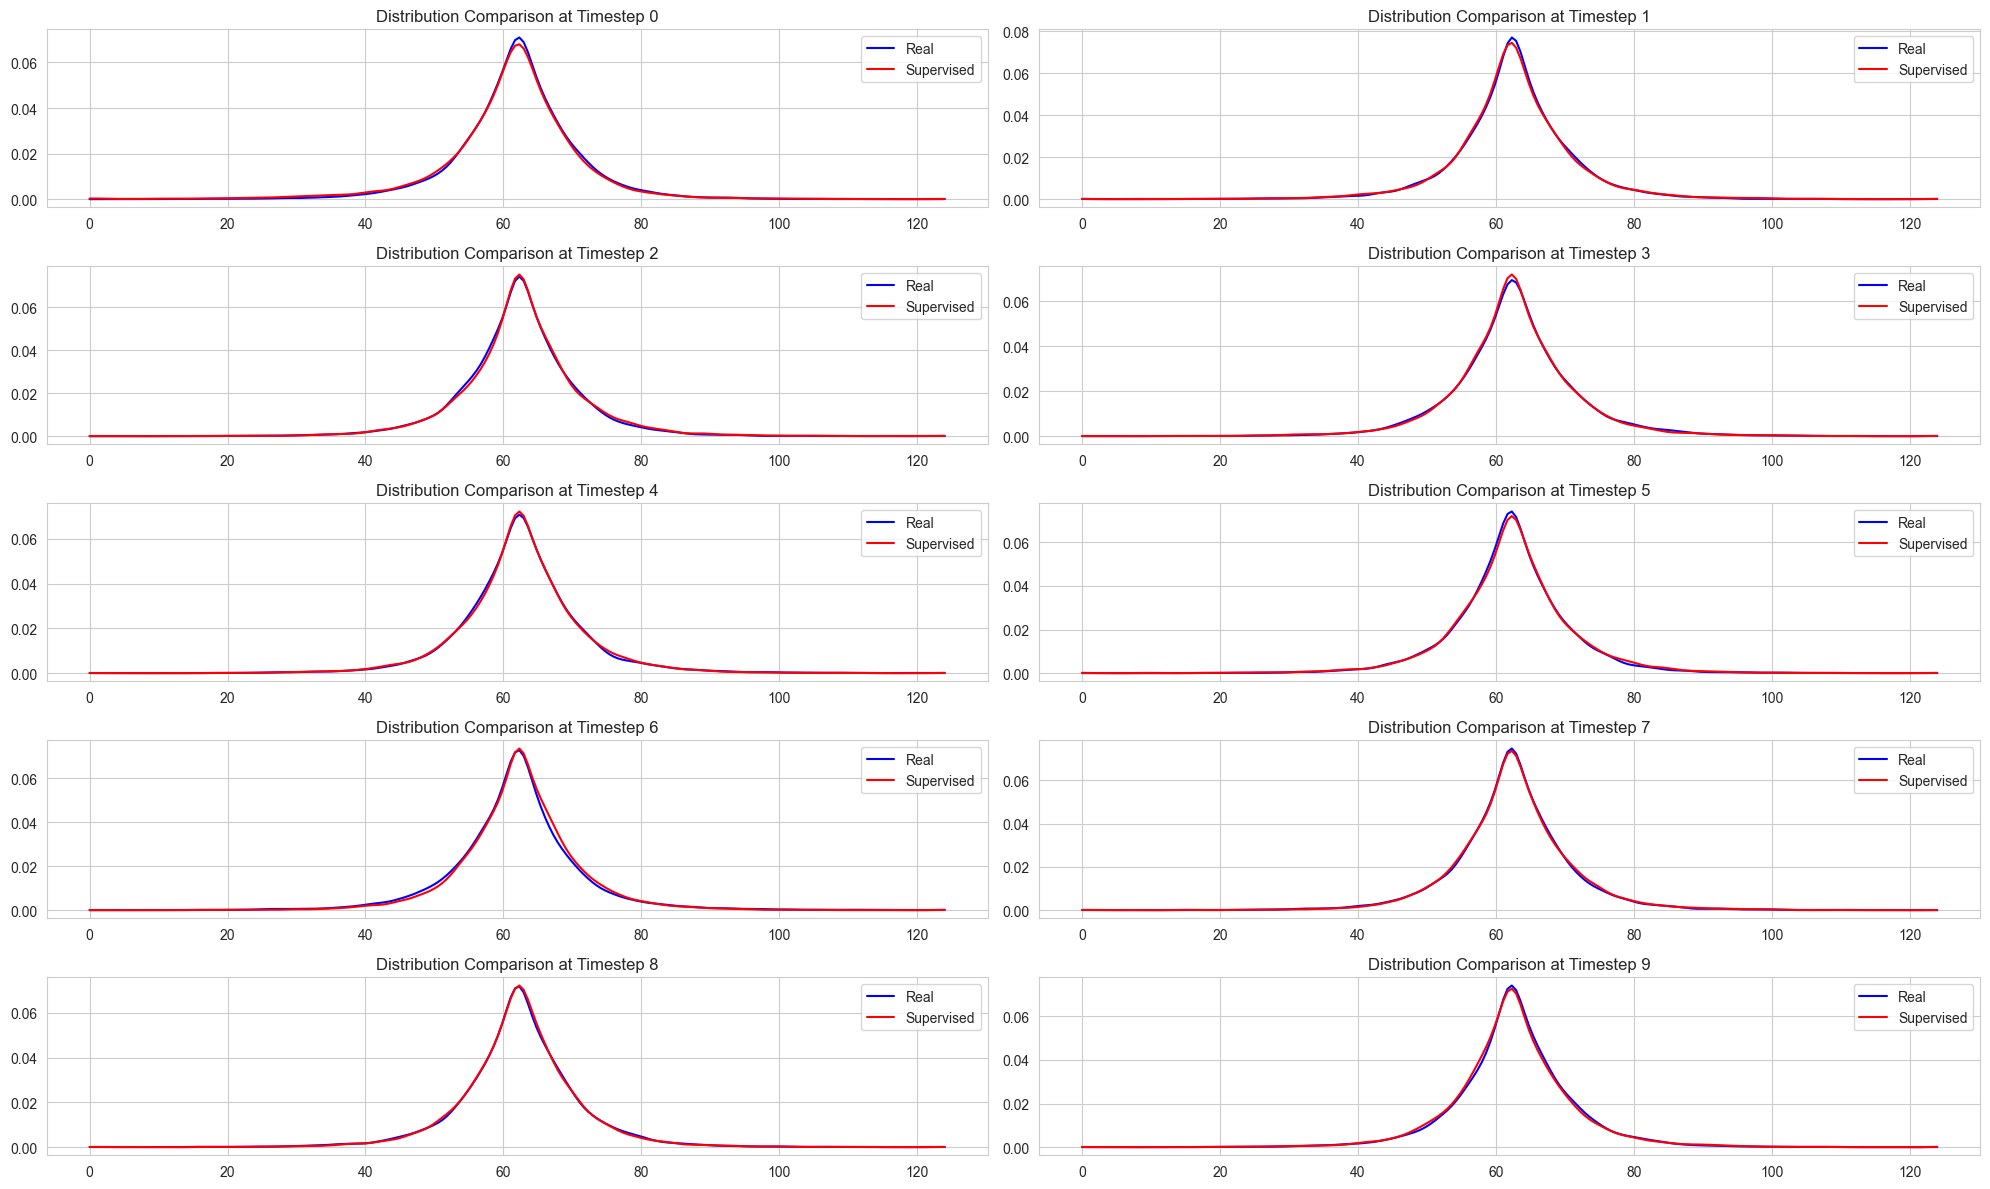

In [36]:
def plot_first_n_distributions(real_data, supervised_data, n_steps=10):
    # Create visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Create a grid of subplots
    rows = (n_steps + 1) // 2  # Calculate number of rows needed
    gs = plt.GridSpec(rows, 2)
    
    for t in range(n_steps):
        # Calculate subplot position
        row = t // 2
        col = t % 2
        
        # Create subplot
        ax = fig.add_subplot(gs[row, col])
        
        # Get data for the timestep
        real_timestep = real_data[:, t]
        generated_timestep = supervised_data[:, t]
        
        # Calculate KDE
        kde_real = gaussian_kde(real_timestep)
        kde_generated = gaussian_kde(generated_timestep)
        
        # Create evaluation points
        x_eval = np.linspace(min(real_timestep.min(), generated_timestep.min()),
                            max(real_timestep.max(), generated_timestep.max()),
                            200)
        
        # Plot distributions
        ax.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
        ax.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
        ax.set_title(f'Distribution Comparison at Timestep {t}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_first_n_distributions(X_test[:,1:], supervised_data, n_steps=10)

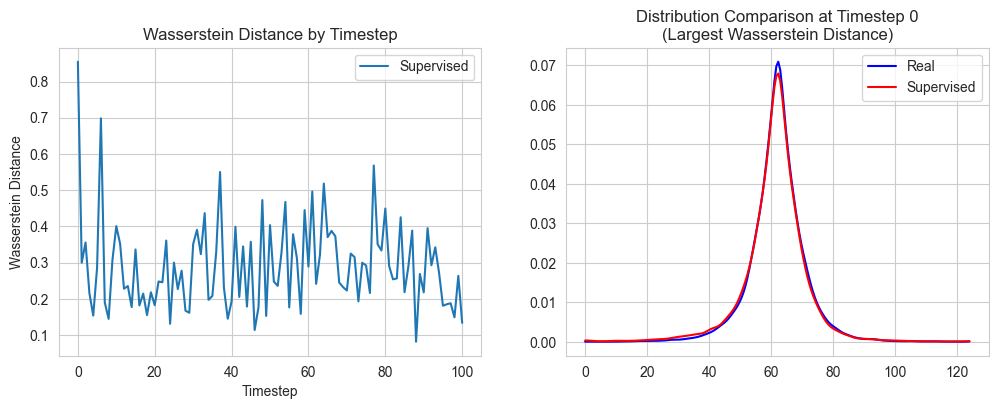

In [37]:
supervised_wasserstein(X_test[:,1:], supervised_data)